2022-09-02 16:19:16.163 | INFO     | __main__:<cell line: 43>:77 - 使用 LASSO 进行特征选择,剩余(1740, 55)个特征
2022-09-02 16:19:16.166 | INFO     | __main__:<cell line: 87>:87 - 虚证： (805, 56),Counter({0: 621, 2: 184})
2022-09-02 16:19:16.167 | INFO     | __main__:<cell line: 88>:88 - 实证： (659, 56),Counter({4: 547, 6: 112})


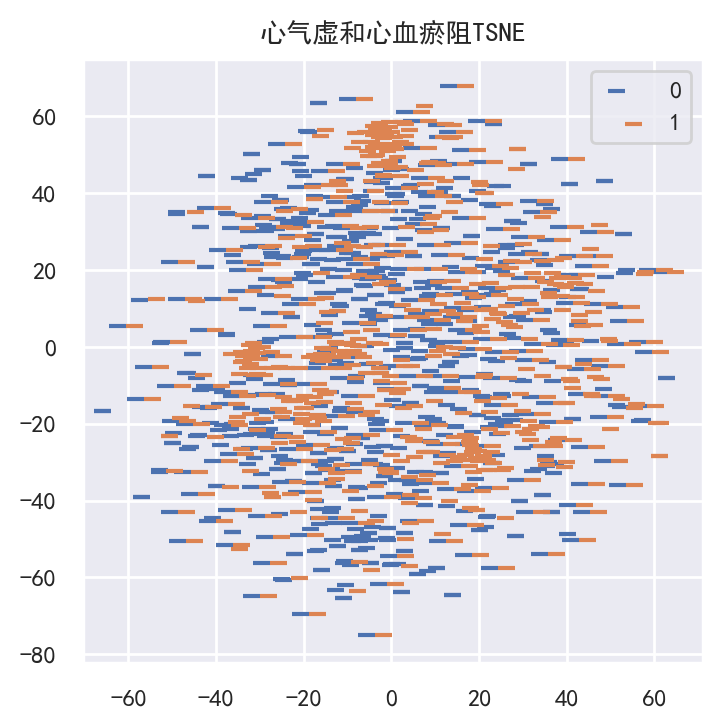

2022-09-02 16:19:18.927 | INFO     | __main__:<cell line: 110>:126 - 使用 SMOTETomek 混合采样
2022-09-02 16:19:18.984 | INFO     | __main__:<cell line: 131>:131 - 采样前[(1, 659), (0, 805)],采样后[(1, 789), (0, 789)]
2022-09-02 16:19:29.843 | INFO     | __main__:<cell line: 164>:164 - {'max_depth': 5, 'grow_policy': 'lossguide', 'learning_rate': 0.000523321282358173, 'gamma': 4.3656065370786675e-05, 'reg_lambda': 0.000320043738382376, 'reg_alpha': 0.005772724727929415, 'subsample': 0.8422345466596775, 'colsample_bytree': 0.2212359138551717}
2022-09-02 16:19:30.626 | WARNING  | __main__:<cell line: 171>:171 - {'fit_time': array([0.07307506, 0.07543206, 0.07473373, 0.0800755 , 0.07874322,
       0.06832314, 0.07011914, 0.0765121 , 0.06929874, 0.0702095 ]), 'score_time': array([0.00399971, 0.00635672, 0.00151181, 0.        , 0.00461197,
       0.        , 0.00801945, 0.00399947, 0.00200868, 0.        ]), 'test_accuracy': array([0.67721519, 0.66455696, 0.56962025, 0.67721519, 0.6835443 ,
       0.6265

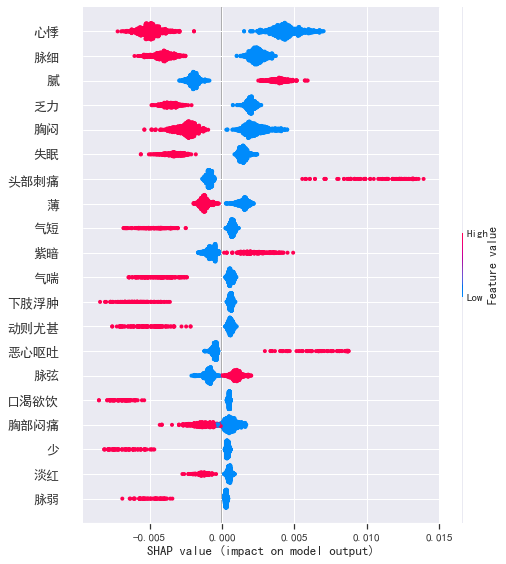

2022-09-02 16:19:31.204 | WARNING  | __main__:<cell line: 172>:185 - 0.665	0.703	0.57	0.629


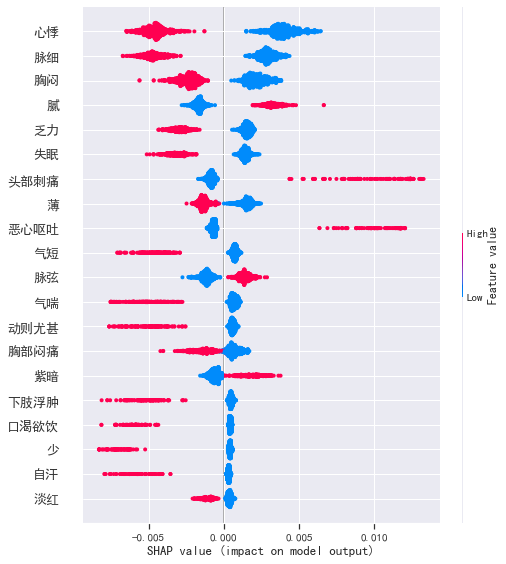

2022-09-02 16:19:31.787 | WARNING  | __main__:<cell line: 172>:185 - 0.57	0.568	0.582	0.575


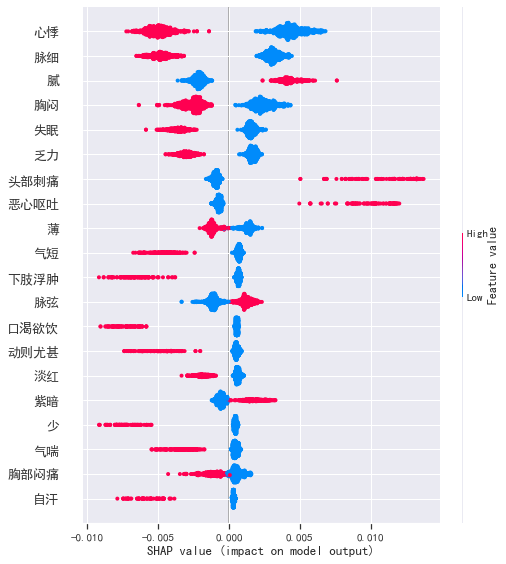

2022-09-02 16:19:32.304 | WARNING  | __main__:<cell line: 172>:185 - 0.677	0.719	0.582	0.643


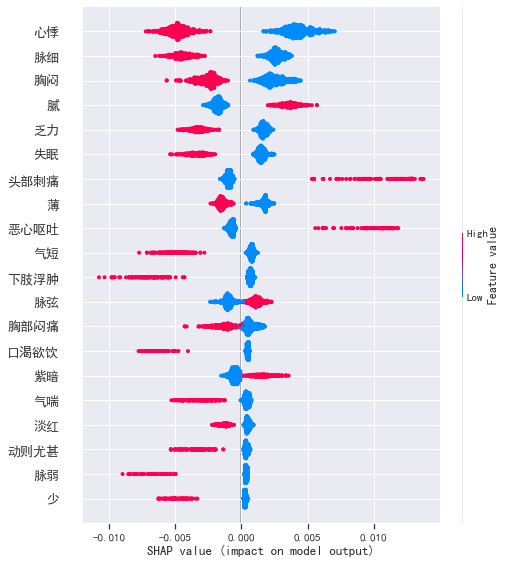

2022-09-02 16:19:32.826 | WARNING  | __main__:<cell line: 172>:185 - 0.684	0.71	0.62	0.662


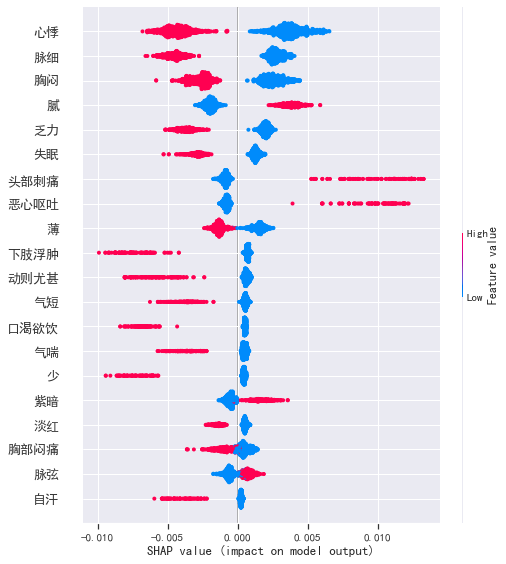

2022-09-02 16:19:33.341 | WARNING  | __main__:<cell line: 172>:185 - 0.627	0.661	0.519	0.582


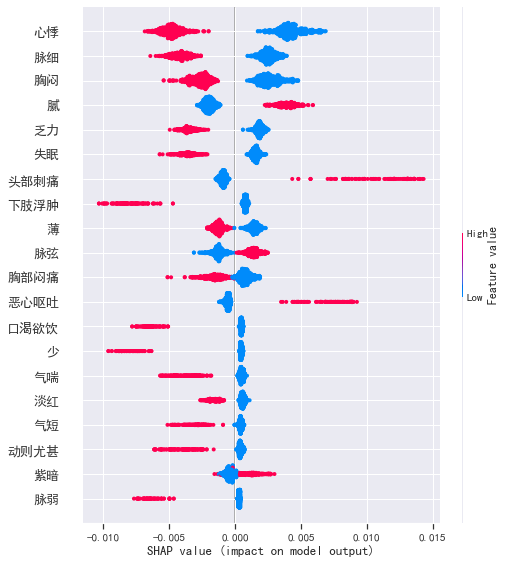

2022-09-02 16:19:33.855 | WARNING  | __main__:<cell line: 172>:185 - 0.665	0.686	0.608	0.644


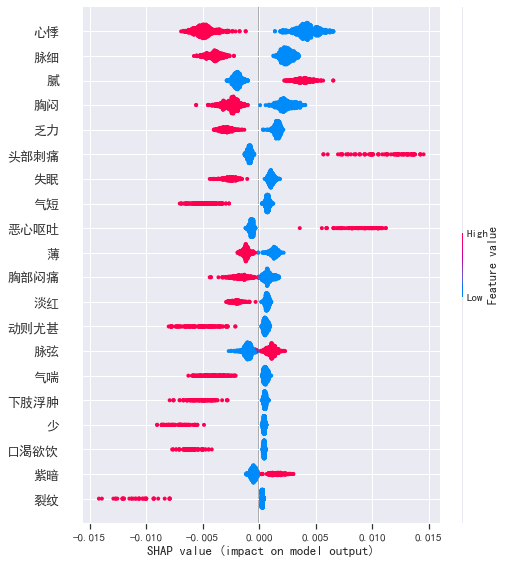

2022-09-02 16:19:34.339 | WARNING  | __main__:<cell line: 172>:185 - 0.62	0.638	0.557	0.595


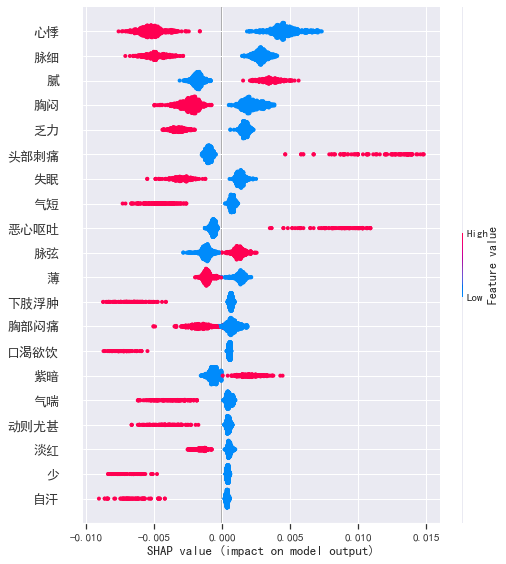

2022-09-02 16:19:34.860 | WARNING  | __main__:<cell line: 172>:185 - 0.643	0.672	0.57	0.616


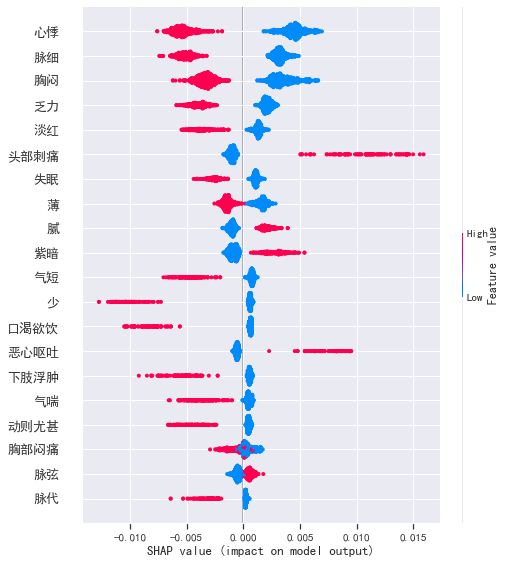

2022-09-02 16:19:35.498 | WARNING  | __main__:<cell line: 172>:185 - 0.618	0.629	0.564	0.595


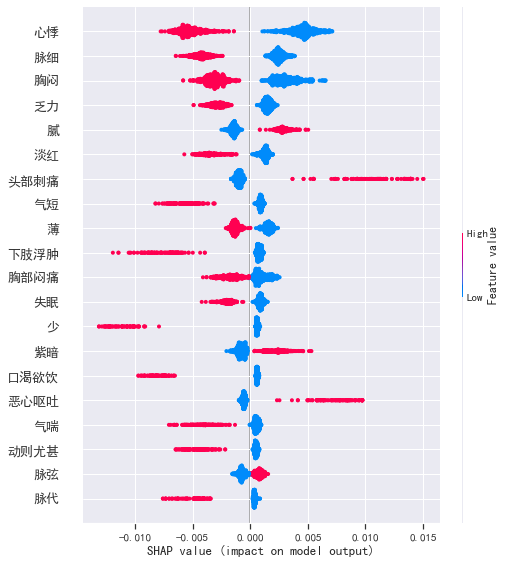

2022-09-02 16:19:35.894 | WARNING  | __main__:<cell line: 191>:191 - accuracy		mean:0.644	std:0.034
2022-09-02 16:19:35.896 | WARNING  | __main__:<cell line: 193>:193 - precision		mean:0.666	std:0.043
2022-09-02 16:19:35.897 | WARNING  | __main__:<cell line: 195>:195 - recall		mean:0.586	std:0.042
2022-09-02 16:19:35.899 | WARNING  | __main__:<cell line: 197>:197 - f1		mean:0.622	std:0.034


In [3]:
# 虚症(心气虚、心血虚、心阴虚、心阳虚)和实证(心血瘀阻证、心火亢盛证、痰蒙心神证、瘀阻脑络证)相对比
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
from cmath import log
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = readJSON('./input/id2feature.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
logger.add('./log/{time}.log')
X, y = preprocess(path='./input/心总表.xlsx', sheet_name='总表')
X.columns = id2feature.values()
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel

    ## category_encoder can't work
    # import category_encoders as ce
    # encoder = ce.TargetEncoder()
    # encoder = ce.CatBoostEncoder()
    # X_ce = encoder.fit_transform(X,y)

    scaler = StandardScaler()
    X_scale = scaler.fit_transform(X, y)
    X_scale = pd.DataFrame(X, columns=scaler.feature_names_in_)
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X_scale, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X_scale.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []
le = LabelEncoder()
y = le.fit_transform(y)
data = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['证名'])], axis=1)
xz = data[(data['证名'] == 0) | (data['证名']==2)]
sz = data[(data['证名'] == 4) | (data['证名'] == 6)]
logger.info(f'虚证： {xz.shape},{Counter(xz["证名"])}')
logger.info(f'实证： {sz.shape},{Counter(sz["证名"])}')
# xqx = xqx.sample(180, random_state=64)
# xxyz = xxyz.sample(120, random_state=64)
xz['证名'] = 0
sz['证名'] = 1
tmp = pd.concat([xz, sz], axis=0).sample(frac=1).reset_index(drop=True)
X = tmp.drop(columns='证名')
y = tmp['证名']

# TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(i))
plt.legend()
plt.title('心气虚和心血瘀阻TSNE')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(
    f'采样前{list(Counter(y).items())},采样后{list(Counter(y_resampled).items())}')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
                    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')
